# Import

In [1]:
import torch
!pip install pyro-ppl==1.3.0
import pyro
import pyro.distributions as dist
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
from random import random
import time

     |████████████████████████████████| 495 kB 43.2 MB/s 


# Dataset initialization

In [2]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
trainX = trainX.reshape(60000, 784)
testX = testX.reshape(10000, 784)

trainX = torch.tensor(trainX)/255
trainy = torch.tensor(trainy)
testX = torch.tensor(testX)/255
testy = torch.tensor(testy)

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
from IPython.display import display

def plot(entry, set_type='train', y_pred=None):
    
    labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
        6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

    if set_type == 'train':
        image = trainX[entry].reshape(28,28)
        plt.imshow(image, cmap='Greys')
        print(entry, labels[int(trainy[entry])])
        plt.show()
    
    elif set_type == 'test':
        image = testX[entry].reshape(28,28)
        plt.imshow(image, cmap='Greys')
        print(entry, "pred:", labels[int(y_pred[entry])], ", true:", labels[int(testy[entry])])
        plt.show()
    
    else:
        print('Invalid set_type')

5190 Trouser


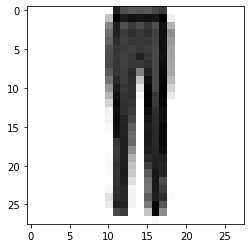

621 Bag


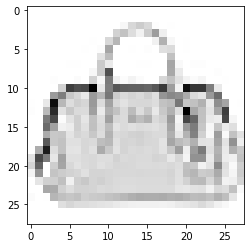

In [4]:
for i in [int(10000*random()) for x in range(2)]:
    plot(i)

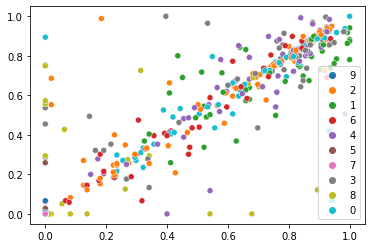

In [ ]:
def scatterplot(x, y):
    colors = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    sns.scatterplot(x[:, 150], x[:, 151], hue=colors[y])
    
scatterplot(testX[:500], testy[:500])

# Logistic regression

In [ ]:
logregmodel = LogisticRegression(max_iter = 1000)
logregmodel.fit(trainX, trainy)
y_pred = logregmodel.predict(testX)
print(classification_report(testy, y_pred))

#Gaussian Naive Bayes

In [ ]:
naiveBayes = GaussianNB()
naiveBayes.fit(trainX, trainy)
y_pred = naiveBayes.predict(testX)
print(classification_report(testy, y_pred))

# Gaussian Process

In [5]:
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem, RBFSampler
import sklearn.gaussian_process as gp_sklearn
import pyro.contrib.gp as gp
from sklearn.decomposition import PCA

(array([457., 556., 504., 501., 488., 493., 493., 512., 490., 506.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

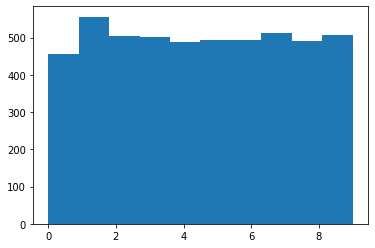

In [ ]:
plt.hist(trainy[:5000])

## Principal Component Analysis

In [ ]:
pca = PCA(n_components=50, copy=True, whiten=False)
trainX = pca.fit_transform(trainX)
testX = pca.fit_transform(testX)
trainX = np.ascontiguousarray(trainX)
testX = np.ascontiguousarray(testX)

In [ ]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
fig = go.Figure(data=go.Scatter(x=list(range(1,len(var)+1)), y=var))
fig.update_layout(title='PCA Variance Explained',
                   xaxis_title='# Of Features',
                   yaxis_title='% Variance Explained')
fig.show()

## RBF kernel

Select parameters:

In [ ]:
RBF = gp_sklearn.kernels.RBF(length_scale_bounds=(1e-5,1))

gpc_RBF = GPC(kernel=RBF, warm_start=True, n_jobs=-1, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=100)
gpc_RBF = gpc_RBF.fit(trainX[:500], trainy[:500])

In [ ]:
gpc_RBF.kernel_.theta   # questi sono il logaritmo del parametro vero

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
print("length_scale = ", np.exp(np.mean(gpc_RBF.kernel_.theta)))

length_scale =  1.0


Fit final model:

In [ ]:
RBF = gp_sklearn.kernels.RBF(length_scale=1)

gpc_RBF = GPC(kernel=RBF, warm_start=True, n_jobs=-1)
gpc_RBF = gpc_RBF.fit(trainX[:5000], trainy[:5000])

In [ ]:
y_pred_RBF = gpc_RBF.predict(testX)
print(classification_report(testy, y_pred_RBF))

## Comparison with different kernels

### Periodic

Select the paramaters:

In [ ]:
periodic = gp_sklearn.kernels.ExpSineSquared(length_scale_bounds=(1e-5,1), periodicity_bounds=(100,200))

gpc_periodic = GPC(kernel=periodic, warm_start=True, n_jobs=-1, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=100)
gpc_periodic = gpc_periodic.fit(trainX[:200], trainy[:200])

In [ ]:
gpc_periodic.kernel_.theta   # questi sono il logaritmo del parametro vero

array([-0.95919333,  5.16571889, -1.25147851,  5.29831737, -0.94681701,
        5.29831737, -0.82813963,  5.13598838, -0.22446299,  4.60517019,
       -1.18071986,  5.29831737,  0.        ,  4.64106741, -1.18262027,
        5.29831737, -0.9492253 ,  5.14193429, -1.17861209,  5.29831737])

In [ ]:
print("length_scale = ", np.exp(np.mean(gpc_periodic.kernel_.theta[0::2])))
print("periodicity = ", np.exp(np.mean(gpc_periodic.kernel_.theta[1::2])))

length_scale =  0.41889838798935547
periodicity =  167.02551725105616


Fit the final model:

In [ ]:
periodic = gp_sklearn.kernels.ExpSineSquared(length_scale=0.4189, periodicity=167.0255)

gpc_periodic = GPC(kernel=periodic, warm_start=True, n_jobs=-1)
gpc_periodic = gpc_periodic.fit(trainX[:5000], trainy[:5000])

In [ ]:
y_pred = gpc_periodic.predict(testX)
print(classification_report(testy, y_pred))

### Polynomial

Select the paramaters:

In [ ]:
product = gp_sklearn.kernels.DotProduct(sigma_0_bounds=(1, 200))
polynomial = gp_sklearn.kernels.Exponentiation(kernel=product, exponent=2)

gpc_polynomial = GPC(kernel=polynomial, warm_start=True, n_jobs=-1, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=100)
gpc_polynomial = gpc_polynomial.fit(trainX[:200], trainy[:200])  

In [ ]:
gpc_polynomial.kernel_.theta   # questi sono il logaritmo del parametro vero

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.69347467, 0.        , 1.39380609, 0.        , 0.        ])

In [ ]:
print("sigma_0 = ", np.exp(np.mean(gpc_polynomial.kernel_.theta))) 

sigma_0 =  1.3616920437889766


Fit the final model:

In [ ]:
product = gp_sklearn.kernels.DotProduct(sigma_0=100)   # con valori bassi di sigma_0 dà errore
polynomial = gp_sklearn.kernels.Exponentiation(kernel=product, exponent=2)

gpc_polynomial = GPC(kernel=polynomial, warm_start=True, n_jobs=-1)
gpc_polynomial = gpc_polynomial.fit(trainX[:500], trainy[:500]) 

In [ ]:
y_pred = gpc_polynomial.predict(testX)
print(classification_report(testy, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1000
           1       0.97      0.92      0.95      1000
           2       0.63      0.69      0.66      1000
           3       0.83      0.77      0.80      1000
           4       0.63      0.74      0.68      1000
           5       0.92      0.85      0.88      1000
           6       0.56      0.53      0.55      1000
           7       0.86      0.84      0.85      1000
           8       0.93      0.88      0.90      1000
           9       0.85      0.94      0.89      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



### Matern

Select the parameters:

In [12]:
t = time.time()

matern = gp_sklearn.kernels.Matern(length_scale_bounds=(1e-5,1), nu=1.5)

gpc_matern = GPC(kernel=matern, warm_start=True, n_jobs=-1, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1)
gpc_matern = gpc_matern.fit(trainX[:4000], trainy[:4000])

print(f"---{(time.time()-t)/60} minutes ---")

---5.707416188716889 minutes ---


In [ ]:
gpc_matern.kernel_.theta  # questi sono il logaritmo del parametro vero

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
print("length_scale = ", np.exp(np.mean(gpc_matern.kernel_.theta)))

length_scale =  1.0


Fit the final model:

In [14]:
t = time.time()

matern = gp_sklearn.kernels.Matern(length_scale=1, nu=1.5)

gpc_matern = GPC(kernel=matern, warm_start=True, n_jobs=-1)
gpc_matern = gpc_matern.fit(trainX[:5000], trainy[:5000])

print(f"---{(time.time()-t)/60} minutes ---")

---112.75166376431783 minutes ---


In [15]:
y_pred = gpc_matern.predict(testX)
print(classification_report(testy, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1000
           1       0.98      0.94      0.96      1000
           2       0.71      0.71      0.71      1000
           3       0.79      0.86      0.82      1000
           4       0.70      0.74      0.72      1000
           5       0.85      0.86      0.86      1000
           6       0.58      0.50      0.54      1000
           7       0.87      0.86      0.87      1000
           8       0.92      0.92      0.92      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [16]:
from sklearn.metrics import confusion_matrix 
cf = confusion_matrix(testy, y_pred)
print("confusion matrix:\n", cf)

confusion matrix:
 [[769   4  14  79   6  12 101   0  15   0]
 [  6 935  15  36   6   1   0   0   1   0]
 [ 10   1 712  10 147   7 100   0  13   0]
 [ 27  12  10 861  33   2  51   0   4   0]
 [  1   3 113  42 740   5  86   0  10   0]
 [  0   0   0   4   0 863   0  80   5  48]
 [169   1 125  46 116  13 498   0  32   0]
 [  0   0   0   0   0  58   0 860   2  80]
 [  1   1  11  12   2  23  23   7 918   2]
 [  0   0   0   0   0  30   0  40   1 929]]


In [22]:
print(gpc_matern.kernel_.theta)


gpc_matern.kernel.get_params()

[2.20626979 2.16909516 2.12919324 2.11339963 2.19756108 2.09495295
 2.11183285 2.16557004 2.13417538 2.26714867]


{'length_scale': 1, 'length_scale_bounds': (1e-05, 100000.0), 'nu': 1.5}

#HMC inference

In [ ]:
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp

In [ ]:
pyro.clear_param_store()
# set kernel and GP
kernel = gp.kernels.RBF(input_dim=784)
gpr = gp.models.GPRegression(trainX[:5], trainy[:5], kernel=kernel)
# set priors and run HMC
gpr.kernel.set_prior("variance", dist.Exponential(1))
gpr.kernel.set_prior("lengthscale", dist.Normal(0., 0.5))
hmc_kernel = HMC(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=4, warmup_steps=10)
mcmc.run()

Text(0.5, 1.0, 'kernel.lengthscale')

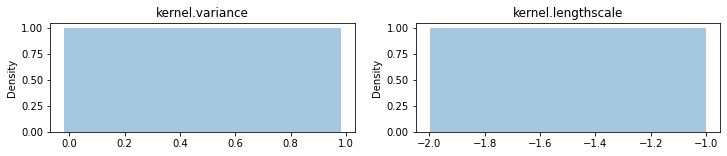

In [ ]:
posterior = mcmc.get_samples()
fig, axes = plt.subplots(1, 2, figsize=(12,2))
sns.distplot(posterior["kernel.variance"], ax=axes[0])
sns.distplot(posterior["kernel.lengthscale"], ax=axes[1])
axes[0].set_title("kernel.variance")
axes[1].set_title("kernel.lengthscale")


In [ ]:
def get_logits(x, mu, sigma, l, eta):

    kernel = gp.kernels.RBF(input_dim=784, variance=torch.tensor(sigma), lengthscale=torch.tensor(l))
    K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
    L = K.cholesky()

    return mu+torch.mv(L,eta)

In [ ]:
def test(x):
    
    N = 80
    mu = pyro.sample("mu", dist.Normal(0,1))
    sigma = pyro.sample("sigma", dist.LogNormal(0,1))
    l = pyro.sample("l", dist.LogNormal(0,1))

    with pyro.plate('observations', N):
        eta = pyro.sample("eta", dist.Normal(0,1))
        logit = torch.stack([get_logits(x, mu=mu, sigma=sigma, l=l, eta=eta) for i in range(9)])
        print(type(logit), len(logit), len(logit[1]))
    return logit 

In [ ]:
x = torch.Tensor(testX.values)
l = test(x[:80])
print(x[:80].shape)
print(len(l))
print(len(l[1]))

<class 'torch.Tensor'> 9 80
torch.Size([80, 784])
9
80


In [ ]:
trainX = torch.Tensor(trainX.values)
trainy = torch.Tensor(trainy.values)

In [ ]:
def gp_classifier(x,y):
    
    N = 80

    mu = pyro.sample("mu", dist.Normal(0,1))
    sigma = pyro.sample("sigma", dist.LogNormal(0,1))
    l = pyro.sample("l", dist.LogNormal(0,1))

    with pyro.plate('observations', N):
        eta = pyro.sample("eta", dist.Normal(0,1))
        logit = torch.stack([get_logits(x, mu=mu, sigma=sigma, l=l, eta=eta) for i in range(9)])
        y_n = pyro.sample("y_n", 
                          dist.Categorical(torch.stack([torch.sigmoid(logit[0]), torch.sigmoid(logit[1]), 
                                                         torch.sigmoid(logit[2]), torch.sigmoid(logit[3]), 
                                                         torch.sigmoid(logit[4]), torch.sigmoid(logit[5]),
                                                         torch.sigmoid(logit[6]), torch.sigmoid(logit[7]), 
                                                         torch.sigmoid(logit[8])])), obs=y)

In [ ]:
kernel = NUTS(model=gp_classifier, jit_compile=True)
mcmc = MCMC(kernel, warmup_steps=50, num_samples=10, num_chains=1)
mcmc.run(x=trainX[:80], y=trainy[:80])

In [ ]:
posterior = mcmc.get_samples()

Text(0.5, 1.0, 'l')

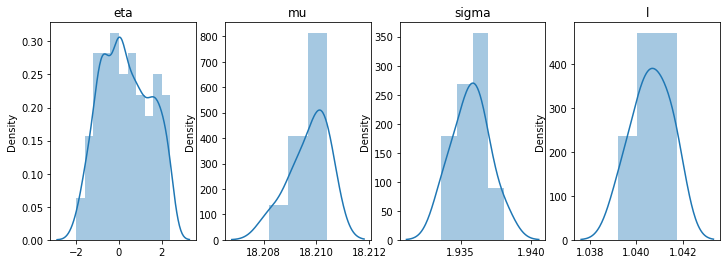

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
sns.distplot(posterior['eta'], ax=axes[0])
sns.distplot(posterior['mu'], ax=axes[1])
sns.distplot(posterior['sigma'], ax=axes[2])
sns.distplot(posterior['l'], ax=axes[3])
axes[0].set_title('eta')
axes[1].set_title('mu')
axes[2].set_title('sigma')
axes[3].set_title('l')

In [ ]:
kernel = gp_sklearn.kernels.RBF(length_scale=posterior['l'].mean())
gpc = GaussianProcessClassifier(kernel=kernel, random_state=16).fit(trainX[:100], trainy[:100])

In [ ]:
y_pred = gpc.predict(testX[:1000])
print(classification_report(testy[:1000], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        97
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       102
           8       0.00      0.00      0.00        98
           9       0.10      1.00      0.19       105

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



In [ ]:
def pred(samples, x ,i):
    kernel = gp.kernels.RBF(input_dim=784, variance=samples['sigma'][i], lengthscale=samples['l'][i])
    y = get_logits(x, samples['mu'][i], samples['sigma'][i], samples['l'][i],  samples['eta'][i])

    with torch.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x, full_cov=True)

    y_hat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
    return yhat.sigmoid().numpy()

In [ ]:
def posterior_predictive(samples, i, x, x_grid):
    kernel = gp.kernels.RBF(input_dim=784, variance=samples['sigma'][i], lengthscale=samples['l'][i]) 
    N_grid = x_grid.shape[0]
    
    y = get_logits(x, samples['mu'][i], samples['sigma'][i], samples['l'][i],  samples['eta'][i])
        
    with torch.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)
        
    yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()    
    return yhat.sigmoid().numpy()

def plot_pyro_predictions(posterior_samples, x):

    n_samples = posterior_samples['sigma'].shape[0]
    x0, x1, x_grid = meshgrid(x, 30) 
    x_grid = torch.from_numpy(x_grid)
    preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])

    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

In [ ]:
plot_pyro_predictions(posterior, x)